In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

%matplotlib inline

# 1. Reading Data
This first part of the notebook is to read and pre process all the data, which are:
- Pfam keyword search data: data gathered by searching nucleus and membrane related words
- T. Cruzi HMM output: T. cruzi data aligned with Pfam database
- Swissprot data: 103 validated t cruzi proteins

## 1.1 Pfam keyword search data

In [2]:
# Pfam proteins associated with nucleus terms and membrane terms in keyword search
df_pfam_locations = pd.read_csv('../input/pfam_nucleus_membrane_data.csv')

In [3]:
df_pfam_locations.keyword.value_counts()

membrane        1904
cytoplasm        357
chromossome      191
chromatin        151
nucleus          120
cytosol          115
nucleic          113
cytoskeleton      50
Name: keyword, dtype: int64

In [4]:
# The searched terms
nucleus_terms = ['chromossome', 'chromatin', 'nucleus', 'nucleic']
membrane_terms = ['membrane', 'cytoplasm', 'cytoskeleton', 'cytosol']

# Add variable to identify if is a nucleus or membrane term
df_pfam_locations['flag_nucleus'] = np.where(df_pfam_locations['keyword'].isin(nucleus_terms), 1, 0)
df_pfam_locations['flag_membrane'] = np.where(df_pfam_locations['keyword'].isin(membrane_terms), 1, 0)
df_pfam_locations.shape

(3001, 6)

In [5]:
# The Pfam keyword search find the same accession in different terms
# so I will group these values
df_pfam_locations = df_pfam_locations.groupby('accession')[['flag_nucleus', 'flag_membrane']].max().reset_index()
df_pfam_locations.head(3)

,accession,flag_nucleus,flag_membrane
0,PF00001,0,1
1,PF00002,0,1
2,PF00003,0,1


In [6]:
df_pfam_locations.flag_membrane.value_counts()

1    2199
0     483
Name: flag_membrane, dtype: int64

In [7]:
df_pfam_locations.flag_nucleus.value_counts()

0    2134
1     548
Name: flag_nucleus, dtype: int64

In [8]:
df_pfam_locations.flag_membrane.sum()

2199

In [9]:
df_pfam_locations.flag_nucleus.sum()

548

In [10]:
df_pfam_locations.accession.unique().shape

(2682,)

## 1.2 Pfam HMM Output

In [11]:
df_hmm = pd.read_csv('../output/df_t_cruzi_hmm.csv', low_memory=False)
df_hmm.shape

(61583, 19)

In [12]:
df_hmm.head(3)

,target_name,accession,query_name,remove,e_value,score,bias,e_value2,score_2,bias_2,exp,reg,clu,ov,env,dom,rep,inc,description_of_target
0,Hus1,PF04005.12,TcCLB.505051.20,-,4.7e-75,252.4,0.0,5.3e-75,252.2,0.0,1.0,1,0,0,1,1,1,1,Hus1-like protein
1,BNR_3,PF13859.6,TcCLB.504593.10,-,2.9e-54,184.5,0.3,2.9e-54,184.5,0.3,2.8,3,1,0,3,3,3,1,BNR repeat-like domain
2,Tr-sialidase_C,PF11052.8,TcCLB.504593.10,-,9.5e-08,32.0,5.5,1.9e-07,31.1,5.5,1.5,1,0,0,1,1,1,1,Trans-sialidase of Trypanosoma hydrophobic C-t...


In [13]:
df_hmm.accession.unique().shape

(7690,)

In [14]:
df_hmm.query_name.unique().shape

(17544,)

In [15]:
# Remove any character after dot in accession ('.')
df_hmm.accession = df_hmm.accession.apply(lambda x: re.sub(r'\..*', '', x.strip()))
# Strip whitespace from target, query name and score
df_hmm.target_name = df_hmm.target_name.apply(lambda x: x.strip())
df_hmm.query_name = df_hmm.query_name.apply(lambda x: x.strip())
df_hmm.head(2)

,target_name,accession,query_name,remove,e_value,score,bias,e_value2,score_2,bias_2,exp,reg,clu,ov,env,dom,rep,inc,description_of_target
0,Hus1,PF04005,TcCLB.505051.20,-,4.7e-75,252.4,0.0,5.3e-75,252.2,0.0,1.0,1,0,0,1,1,1,1,Hus1-like protein
1,BNR_3,PF13859,TcCLB.504593.10,-,2.9e-54,184.5,0.3,2.9e-54,184.5,0.3,2.8,3,1,0,3,3,3,1,BNR repeat-like domain


In [16]:
print("Unique target_name: " + str(len(df_hmm.target_name.unique())))
print("Unique accession: " + str(len(df_hmm.accession.unique())))
print("Unique query_name: " + str(len(df_hmm.query_name.unique())))
print("Unique query_name + accession: " + str(len((df_hmm.query_name + df_hmm.accession).unique())))

Unique target_name: 7690
Unique accession: 7690
Unique query_name: 17544
Unique query_name + accession: 61583


## 1.3 Swissprot blast data

In [17]:
df_swissprot = pd.read_csv('../output/df_swiss_prot_t_cruzi.csv')
df_swissprot.drop('Unnamed: 0', axis=1, inplace=True)
df_swissprot.dropna(inplace=True)
df_swissprot.shape

(95, 4)

In [18]:
# Transforming variables
df_swissprot['accession_2'] = df_swissprot.iteration_query_def.str.split('|', expand=True).iloc[:,1]
df_swissprot['query_name'] = df_swissprot.query_id.str.split('|', expand=True).iloc[:,0]
df_swissprot['query_name'] = df_swissprot.query_name.apply(lambda x: str(x).strip())
df_swissprot.head(3)

,iteration_query_def,aln_length,flag_hit,query_id,accession_2,query_name
0,sp|Q9GT49|TRYS_TRYCC Trypanothione synthetase ...,647,1,TcCLB.509319.90 | organism=Trypanosoma_cruzi_C...,Q9GT49,TcCLB.509319.90
1,sp|P28593|TYTR_TRYCR Trypanothione reductase O...,492,1,TcCLB.503555.30 | organism=Trypanosoma_cruzi_C...,P28593,TcCLB.503555.30
2,sp|Q9U6Z1|KM11_TRYCR Kinetoplastid membrane pr...,92,1,TcCLB.510755.89 | organism=Trypanosoma_cruzi_C...,Q9U6Z1,TcCLB.510755.89


In [19]:
df_swissprot.dropna().shape

(95, 6)

In [20]:
print("Unique accession_2: " + str(len(df_swissprot.accession_2.unique())))
print("Unique query_name: " + str(len(df_swissprot.query_name.unique())))

Unique accession_2: 95
Unique query_name: 93


In [21]:
df_swissprot.flag_hit.value_counts()

1     92
10     1
6      1
2      1
Name: flag_hit, dtype: int64

___

# 2. Join Data
Now it will be required to join this 3 different datasets.

The 95 swissprot entries will be our training data and we'll join the T. Cruzi hmm output and join by 'query_name' to get 'acession' and 'score' information.

Now with the 'accession' column we can match our pfam keywords data, and create our training set.

## 2.1 Join T. Cruzi hmm on Swissprot data

In [22]:
df_model = df_hmm[['accession', 'query_name', 'score']].merge(df_swissprot[['query_name', 'accession_2']], how='left')
df_model.shape

(61587, 4)

In [23]:
df_model.accession_2.notna().sum()

418

## 2.2 Add Pfam keywords

In [24]:
df_model = df_model.merge(df_pfam_locations, how='left')
df_model.shape

(61587, 6)

In [25]:
df_train = df_model[df_model.accession_2.notna()].reset_index(drop=True)
df_train.shape

(418, 6)

In [26]:
df_pred = df_model[df_model.accession_2.isna()].reset_index(drop=True)
df_pred.shape

(61169, 6)

In [27]:
df_train['score_nucleus'] = np.where(df_train.flag_nucleus.isna(), df_train.score, df_train.flag_nucleus*df_train.score)
df_train['score_membrane'] = np.where(df_train.flag_membrane.isna(), df_train.score, df_train.flag_membrane*df_train.score)

df_pred['score_nucleus'] = np.where(df_pred.flag_nucleus.isna(), df_pred.score, df_pred.flag_nucleus*df_pred.score)
df_pred['score_membrane'] = np.where(df_pred.flag_membrane.isna(), df_pred.score, df_pred.flag_membrane*df_pred.score)

In [28]:
df_train = df_train.groupby('query_name')[['score_nucleus', 'score_membrane']].sum().reset_index()
df_pred = df_pred.groupby('query_name')[['score_nucleus', 'score_membrane']].sum().reset_index()

In [29]:
df_train['classification'] = np.where(df_train.score_nucleus>df_train.score_membrane, 1, 0)
df_train.loc[df_train.score_nucleus==df_train.score_membrane, 'classification'] = 'draw'

df_pred['classification'] = np.where(df_pred.score_nucleus>df_pred.score_membrane, 1, 0)
df_pred.loc[df_pred.score_nucleus==df_pred.score_membrane, 'classification'] = 'draw'

In [30]:
df_train.classification.value_counts()

draw    63
0       24
1        6
Name: classification, dtype: int64

In [31]:
df_pred.classification.value_counts()

draw    12706
0        3716
1        1029
Name: classification, dtype: int64

In [32]:
df_train.to_csv('../output/df_train.csv', index=False)

___

# 3. Random Forest Model

## 3.1 Import RF and create leave one out function 

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
def leave_one_out(X, y, model):
    import pandas as pd
    from sklearn.metrics import accuracy_score, precision_score, recall_score

    df_loo = pd.DataFrame(columns={'true','pred'})

    for i in range(0, X.shape[0]):

        X_train = X[~X.index.isin([i])]
        y_train = y[~y.index.isin([i])]

        X_test = X[X.index.isin([i])]
        y_test = y[y.index.isin([i])]
        

        # Train
        model.fit(np.array(X_train), list(y_train))
        # Make predictions
        y_pred = model.predict(np.array(X_test))

        df_loo.loc[i, 'true'] = int(y_test.values)
        df_loo.loc[i, 'pred'] = int(y_pred)
        
    print("Accuracy: " + str(accuracy_score(df_loo.true, df_loo.pred)))
    print("Precision: " + str(precision_score(df_loo.true, df_loo.pred)))
    print("Recall: " + str(recall_score(df_loo.true, df_loo.pred)))
    
    acc = accuracy_score(df_loo.true, df_loo.pred)
    prec = precision_score(df_loo.true, df_loo.pred)
    rec = recall_score(df_loo.true, df_loo.pred)
    
    return df_loo, acc, prec, rec

## 3.2 Create features and label

In [35]:
rf_model = RandomForestClassifier(n_estimators=10, random_state=42)

In [36]:
X_train = df_train.loc[df_train.classification!='draw', ['score_nucleus','score_membrane']].reset_index(drop=True)
y_train = df_train.loc[df_train.classification!='draw', 'classification'].reset_index(drop=True)

## 3.3 Train

In [37]:
results_acc = []
results_prec = []
results_rec = []

In [38]:
for i in list(range(1,51)):
    _, acc, prec, rec = leave_one_out(X_train, y_train, RandomForestClassifier(n_estimators=i, random_state=42))
    results_acc.append(acc)
    results_prec.append(prec)
    results_rec.append(rec)
    print('\n')

Accuracy: 0.9
Precision: 0.7142857142857143
Recall: 0.8333333333333334


Accuracy: 0.8666666666666667
Precision: 0.75
Recall: 0.5


Accuracy: 0.9
Precision: 0.8
Recall: 0.6666666666666666


Accuracy: 0.9333333333333333
Precision: 1.0
Recall: 0.6666666666666666


Accuracy: 0.9666666666666667
Precision: 1.0
Recall: 0.8333333333333334


Accuracy: 0.9666666666666667
Precision: 1.0
Recall: 0.8333333333333334


Accuracy: 0.9666666666666667
Precision: 1.0
Recall: 0.8333333333333334


Accuracy: 0.9666666666666667
Precision: 1.0
Recall: 0.8333333333333334


Accuracy: 0.9666666666666667
Precision: 1.0
Recall: 0.8333333333333334


Accuracy: 0.9666666666666667
Precision: 1.0
Recall: 0.8333333333333334


Accuracy: 0.9333333333333333
Precision: 0.8333333333333334
Recall: 0.8333333333333334


Accuracy: 0.9333333333333333
Precision: 0.8333333333333334
Recall: 0.8333333333333334


Accuracy: 0.9333333333333333
Precision: 0.8333333333333334
Recall: 0.8333333333333334


Accuracy: 0.9333333333333333
Precis

In [39]:
df_results = pd.concat([pd.Series(list(range(1,51))),
                        pd.Series(results_acc),
                        pd.Series(results_prec),
                        pd.Series(results_rec)],axis=1)

df_results.columns = ['n_estimators','accuracy','precision','recall']

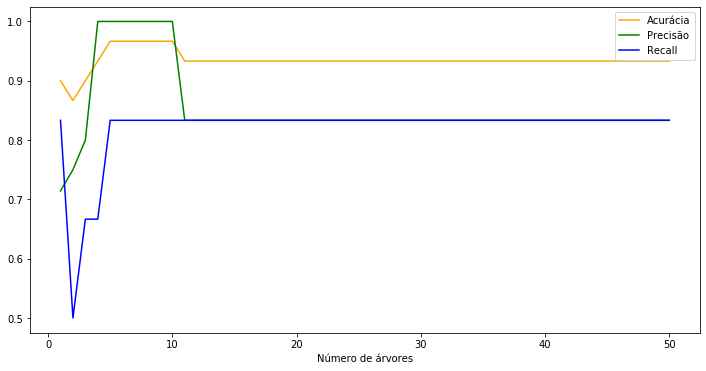

In [40]:
plt.figure(figsize=(12,6))

# multiple line plot
plt.plot('n_estimators', 'accuracy', data=df_results, color='orange', label="Acurácia")
plt.plot('n_estimators', 'precision', data=df_results, color='green', label="Precisão")
plt.plot('n_estimators', 'recall', data=df_results, color='blue', label="Recall")
plt.xlabel('Número de árvores')
plt.legend();


In [41]:
rf_model = RandomForestClassifier(n_estimators=11, random_state=42)

df_model = leave_one_out(X_train, y_train, rf_model)

Accuracy: 0.9333333333333333
Precision: 0.8333333333333334
Recall: 0.8333333333333334


In [42]:
df_model[0]

,pred,true
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
5,1.0,1.0
6,0.0,0.0
7,0.0,0.0
8,0.0,0.0
9,0.0,1.0


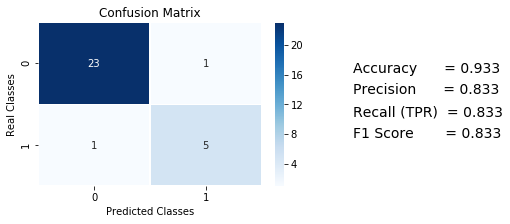

In [43]:
# Cria funcao para plotar a matriz de confusao
def PlotCM(y_test, pred):
    
    from sklearn.metrics import confusion_matrix, classification_report
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    # Cria CM e CM normalizada
    cm_matrix = confusion_matrix(y_test, pred)
    cm_matrix_norm = cm_matrix / cm_matrix.astype(np.float).sum(axis=1)
    
    # Plota CM
    fig, ax = plt.subplots(figsize=(5,3))
    
    sns.heatmap(cm_matrix, cmap=plt.cm.Blues, linewidths=0.5, annot=True, fmt='g', ax=ax)
    plt.title('Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')
    
    TP = cm_matrix[1,1]
    FN = cm_matrix[1,0]
    FP = cm_matrix[0,1]
    TN = cm_matrix[0,0]
    T = TP+FN+FP+TN
    
    fig.text(1,0.65,'Accuracy      = {:.3f}'.format((TP+TN)/T), fontsize=14)
    fig.text(1,0.55,'Precision      = {:.3f}'.format(TP/(TP+FP)), fontsize=14)
    fig.text(1,0.45,'Recall (TPR)  = {:.3f}'.format(TP/(TP+FN)), fontsize=14)
    fig.text(1,0.35,'F1 Score       = {:.3f}'.format(2*TP/(2*TP+FP+FN)), fontsize=14)
    
    plt.show();
    
    
PlotCM(df_model[0].true, df_model[0].pred)

## 3.4 Predict

In [44]:
rf_model = RandomForestClassifier(n_estimators=11, random_state=42)
rf_model.fit(np.array(X_train), list(y_train))

df_pred['preds'] = pd.DataFrame(rf_model.predict(df_pred[['score_nucleus','score_membrane']]))

In [45]:
df_pred.to_csv('../output/df_predictions.csv', index=False)